In [1]:
import numpy as np
import pandas as pd

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

# 0. Inicializando Ambiente Django no Notebook

In [2]:
import os, sys
sys.path.insert(0, os.path.abspath('..'))

from django_for_jupyter import init_django
init_django('app')

# 1. Lendo do Banco de Dados e Salvando em um DataFrame Pandas

In [3]:
from api.models import TextosJuridicosTreinamento

qs = TextosJuridicosTreinamento.objects.all()
data = qs.values('teor_texto', 'orgao_julgador', 'classe_processo', 'assuntos', 'setor_destino')

df = pd.DataFrame(data)
df.head(3)

,teor_texto,orgao_julgador,classe_processo,assuntos,setor_destino
0,PODER JUDICIÁRIO ESTADO DO RIO GRANDE DO NORTE...,2ª VIJ da Com. Natal,1706,12485;12494,Saúde
1,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,3º JFP da Com. Natal,14695,10715,Administrativa
2,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,5ª VEFT de Natal,156,9518,Fiscal


In [4]:
df['setor_destino'].value_counts()

setor_destino
Fiscal            6686
Administrativa    5403
Contabilidade     1338
Judicial          1137
Saúde              443
Meio Ambiente      155
Patrimonial        121
Name: count, dtype: int64

# 2. Train/Test Split

In [65]:
from sklearn.model_selection import train_test_split

# X = df['teor_texto'].to_numpy()
# y = df['setor_destino'].to_numpy()
# classes = np.unique(y)

X = df[["teor_texto", "orgao_julgador"]]
y = df['setor_destino']
classes = np.unique(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

print(f'Shape Treinamento: {X_train.shape}')
print(f'Shape Teste: {X_test.shape}')


Shape Treinamento: (10239, 2)
Shape Teste: (5044, 2)


# 3. Feature Extraction / Transformadores

In [22]:
import nltk
from nltk.corpus import stopwords

# Baixar a lista de stopwords (necessário apenas na primeira vez)
try:
    stopwords.words('portuguese')
except LookupError:
    nltk.download('stopwords')

stopwords_pt = stopwords.words('portuguese')
print(f'TOtal de stopwords em português: {len(stopwords_pt)}')

TOtal de stopwords em português: 207


In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression


preprocessor = ColumnTransformer(
    transformers=[
        ('text-features', TfidfVectorizer(max_features=3500, stop_words=stopwords_pt, max_df=0.6), 'teor_texto'),
        ('categorical-features', CountVectorizer(tokenizer=lambda x: [x], lowercase=True), 'orgao_julgador')
    ],
    remainder='passthrough'
)


estimators = [
    ('rf', RandomForestClassifier(class_weight='balanced')),
    ('svm', LinearSVC(class_weight='balanced'))
]

stacking_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('stacking', StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(class_weight='balanced')))
])

In [90]:
stacking_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text-features',
                                                  TfidfVectorizer(max_df=0.6,
                                                                  max_features=3500,
                                                                  stop_words=['a',
                                                                              'à',
                                                                              'ao',
                                                                              'aos',
                                                                              'aquela',
                                                                              'aquelas',
                                                                              'aquele',
                                                                              'aqueles',
                                                                              'aquilo',
                                                                              'as',
                                                                              'às',
                                                                              'até',
                                                                              'com',
                                                                              'como',
                                                                              'da',
                                                                              'das',
                                                                              'de',
                                                                              'dela',
                                                                              'delas',
                                                                              'dele',
                                                                              'deles',
                                                                              'depois',
                                                                              'do',
                                                                              'dos',
                                                                              'e',
                                                                              'é',
                                                                              'ela',
                                                                              'elas',
                                                                              'ele',
                                                                              'eles', ...]),
                                                  'teor_texto'),
                                                 ('categorical-features',
                                                  CountVectorizer(tokenizer=<function <lambda> at 0x761ef602f6a0>),
                                                  'orgao_julgador')])),
                ('stacking',
                 StackingClassifier(estimators=[('rf',
                                                 RandomForestClassifier(class_weight='balanced')),
                                                ('svm',
                                                 LinearSVC(class_weight='balanced'))],
                                    final_estimator=LogisticRegression(class_weight='balanced')))])

# 4. Classificação

In [39]:
from sklearn.utils.class_weight import compute_class_weight

classes_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

for _class, weight in zip(classes, classes_weights):
    print(f'{_class:<14}: {weight:.3f}')

Administrativa: 0.404
Contabilidade : 1.632
Fiscal        : 0.327
Judicial      : 1.920
Meio Ambiente : 14.065
Patrimonial   : 18.058
Saúde         : 4.925


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def plot_classification_results(y_true, y_pred):
    # Matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Cria uma matriz de anotação combinando counts e porcentagem (será utilizado para o parâmetro 'annot' do heatmap)
    annot_matrix = np.empty_like(cm, dtype=object)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            percentage = cm_norm[i, j] * 100
            annot_matrix[i, j] = f'{count}\n{percentage:.2f}%'

    # Subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Matriz de confusão
    sns.heatmap(cm_norm, annot=annot_matrix, fmt='s', cmap='Blues',
                xticklabels=classes, yticklabels=classes, ax=axes[0], cbar=False, vmin=0, vmax=1)
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
    axes[0].set_title('Matriz de Confusão')
    axes[0].set_xlabel('Predito')
    axes[0].set_ylabel('Real')

    # Classification report
    report_text = classification_report(y_true, y_pred, zero_division=0)
    axes[1].axis('off')
    axes[1].set_title('Classification Report', fontsize=14, loc='left')
    axes[1].text(0, 1, report_text, fontsize=14, family='monospace', verticalalignment='top')

    plt.tight_layout()
    plt.show()


## 4.1 - Random Forest

In [95]:
y_pred = stacking_clf.predict(X_test)

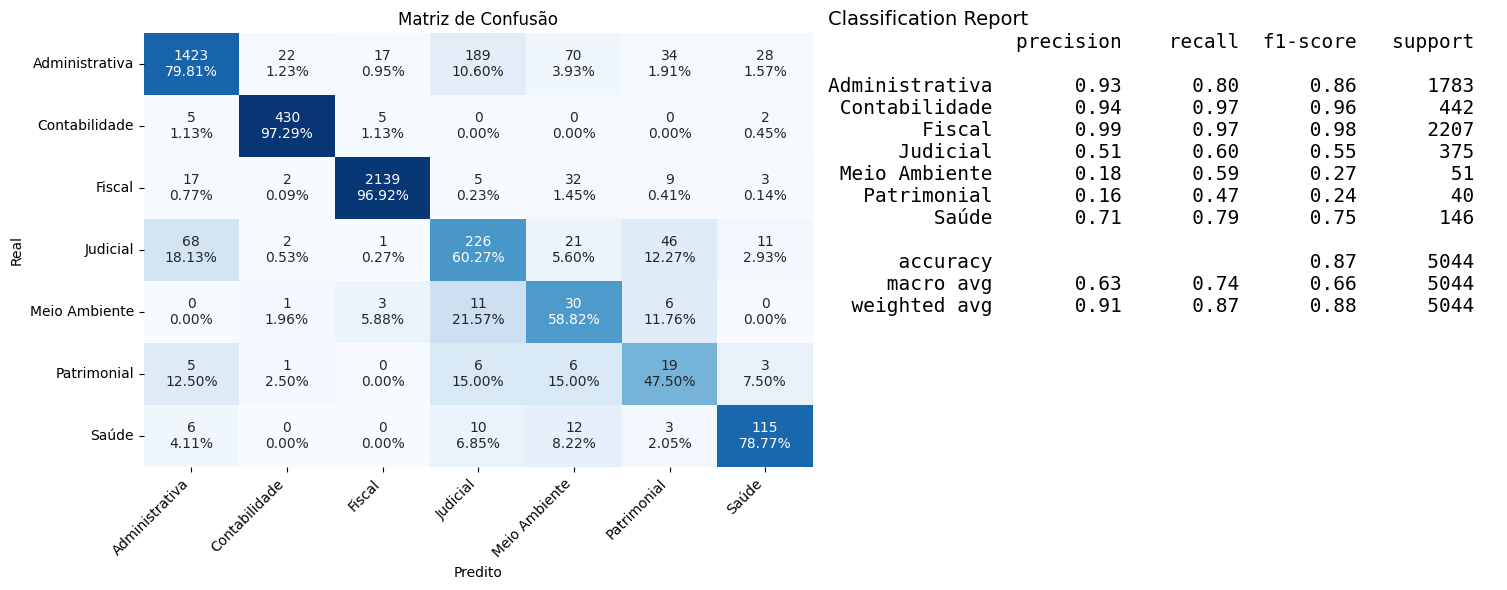

In [96]:
plot_classification_results(y_true=y_test, y_pred=y_pred)

## 4.2 - SVM

In [ ]:
from sklearn.svm import LinearSVC

svm_clf = LinearSVC()